In [128]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [129]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [130]:
df = df_origin[df_origin.Site_Name=='Caesarea']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [131]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [132]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(433, 8)
(433, 7)


In [133]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [134]:
dfLastYearVisits.sort_values('Date')
X = dfLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [137]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(128,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [123]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsCeasarea.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
267/276 [============================>.] - ETA: 0s - loss: 1592453.1250 - mae: 1010.7283 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 1356617.37500, saving model to weightsCeasarea.h5
276/276 [==============================] - 1s 2ms/step - loss: 1547914.2500 - mae: 989.7426 - accuracy: 0.0000e+00 - val_loss: 1356617.3750 - val_mae: 800.1507 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
267/276 [============================>.] - ETA: 0s - loss: 591274.0000 - mae: 497.7610 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 1356617.37500 to 667877.81250, saving model to weightsCeasarea.h5
276/276 [==============================] - 0s 2ms/step - loss: 574229.8125 - mae: 489.2397 - accuracy: 0.0000e+00 - val_loss: 667877.8125 - val_mae: 581.7977 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
257/276 [==========================>...] - ETA: 0s - loss: 492150.3438 - mae: 481.5455 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 667877.81

In [138]:
model.load_weights('weightsCeasarea.h5')

11/11 [==============================] - 0s 1ms/step

mae 436.31019433523187
rmse 619.9920359113404
std 780.967600162725


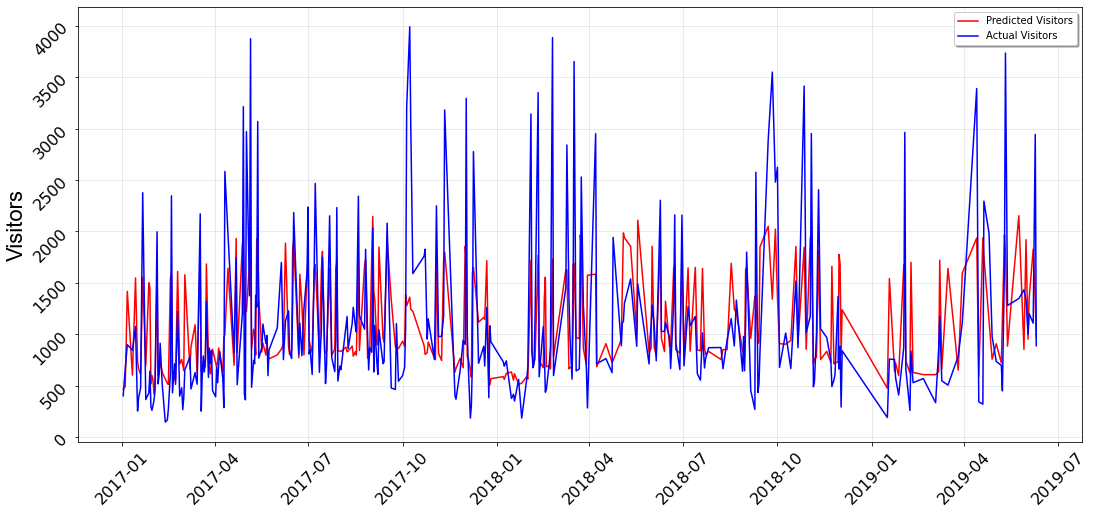

,Prediction,Actual
Date,,
2017-01-02,467.676178,401
2017-01-04,489.822510,663
2017-01-06,1417.591919,898
2017-01-11,602.776123,845
2017-01-14,1547.315063,1075
2017-01-16,732.132446,253
2017-01-17,665.659668,382
2017-01-19,608.855103,480
2017-01-21,1556.128296,2377


In [139]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

3/3 [==============================] - 0s 1ms/step

mae 493.2444784230199
rmse 649.6406020334791
std 793.901068849987


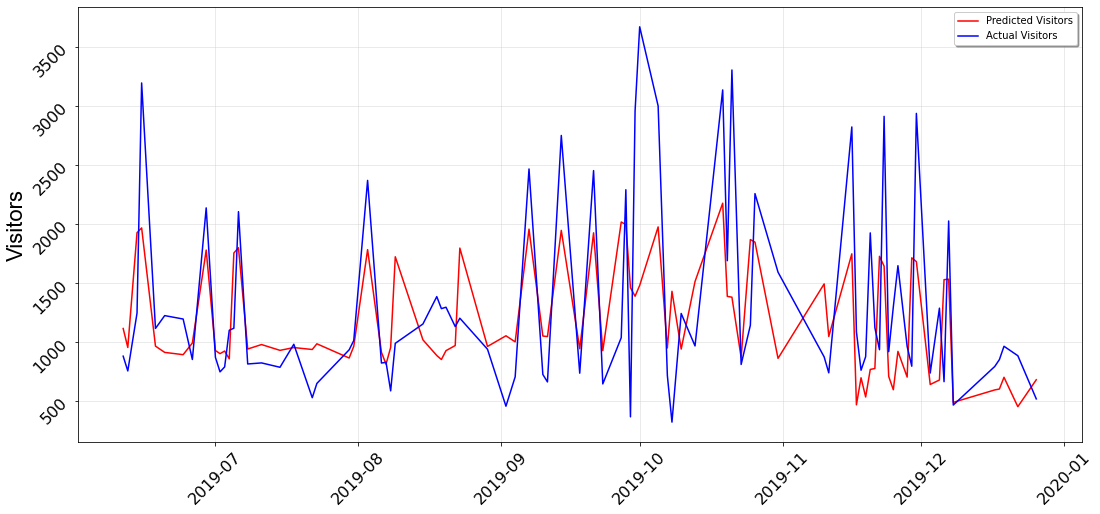

,Prediction,Actual
Date,,
2019-06-11,1115.642456,881
2019-06-12,954.709045,756
2019-06-14,1927.792969,1246
2019-06-15,1968.190918,3197
2019-06-18,966.332520,1116
2019-06-20,913.226990,1225
2019-06-24,893.825500,1196
2019-06-26,992.584656,853
2019-06-29,1780.389404,2138


In [140]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [141]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(346, 6)
(3,)
(346, 6)
index  48 :: Actual values =  3673
index  48 :: Prediction values =  1481.1036376953125
157/157 [==============================] - 0s 1ms/step
Intercept 1549.8422539492517
Prediction_local [1413.3640495]
Right: 1481.1036


,0
is weekend,957.220491
IsHoliday,383.409154
Temperature,217.423863
IsVacation,-124.115476
last year visitors,81.186721
pm10,14.607072
